In [261]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from sweref99 import projections
import folium
from folium import plugins
from selenium import webdriver
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output

In [262]:
path='./data/Insatser till brand i skog och mark 2000-2020.xlsx'

In [263]:
#tm is used for the conversions of easting and northing to longitude and latitude
tm = projections.make_transverse_mercator("SWEREF_99_TM")

In [264]:
df = pd.read_excel(path)


In [265]:
#Here are our headers!
df['TotArea'] = df['arealProduktivSkogsmark_m2']+df['arealAnnanTradbevuxenMark_m2']+df['arealMarkUtanTrad_m2']
df['Acres'] = df['TotArea']/4046.86
df.head(1)


ar      datum       tid  kommun kommunKortNamn  \
0  2000 2000-01-01  00:07:00    1272       Bromölla   

                           verksamhetText  sweref99Norr  sweref99Ost  \
0  Verksamhet inte knuten till en byggnad        6856.0    -905921.0   

            BEJBbrandorsakText  arealProduktivSkogsmark_m2  \
0  Fyrverkeri eller pyroteknik                           0   

   arealAnnanTradbevuxenMark_m2  arealMarkUtanTrad_m2  TotArea     Acres  
0                             6                     0        6  0.001483

In [266]:
print(df.shape)


(100307, 14)


In [267]:
#Here I copy the dataframe to not have to read the csv files if i accidently overwrites the dataframe.
copy_df = df

In [268]:
#Getting all causes for a fire 
copy_df['BEJBbrandorsakText'].unique()

array(['Fyrverkeri eller pyroteknik', 'Okänd', 'Annan',
       'Barns lek med eld', 'Annan eldning', 'Avsiktlig brand',
       'Övriga gnistor',
       'Återantändning av brand från tidigare räddningsinsats',
       'Självantändning - biologisk eller kemisk',
       'Grillning eller lägereld', 'Blixtnedslag', 'Heta arbeten',
       'Rökning', 'Tågbromsning', 'Fel i utrustning', 'Uppgift saknas'],
      dtype=object)

In [269]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [270]:
#Filter rows on cause of fire and only keeping "Annan". "Okänd", "Grillning eller lägereld" and "Uppgift saknas"
copy_df = filter_rows_by_values(copy_df, 'BEJBbrandorsakText', ['Fyrverkeri eller pyroteknik', 'Annan',
       'Barns lek med eld', 'Annan eldning', 'Avsiktlig brand',
       'Övriga gnistor',
       'Återantändning av brand från tidigare räddningsinsats',
       'Självantändning - biologisk eller kemisk', 'Blixtnedslag', 'Heta arbeten',
       'Rökning', 'Tågbromsning', 'Fel i utrustning', 'Uppgift saknas'])

In [271]:
#I drop all fires smaller than one acre and only keep fires that . I check how many fires are left.
#copy_df = copy_df[copy_df.Acres>1]
#copy_df = copy_df
print(copy_df.shape)

(45922, 14)


In [272]:
#To not get to many values I have made a random sample of X fires.
sample = copy_df#.sample(25, replace=True)

In [273]:
for column in sample:
    if sample[column].isnull().any():
       print('{0} has {1} null values'.format(column, sample[column].isnull().sum()))

sweref99Norr has 9118 null values
sweref99Ost has 9117 null values


In [274]:
#Function that calculates number of missing data in column of dataframe and prints result.
def missing(df,column):
       x = len(df)
       if df[column].isnull().any():
           print('{0} has total of {1} null values'.format(column, df[column].isnull().sum()))
           print ('In the column {0}'.format(column), round(100-(df[column].count()/x * 100), 3), '% of the cells have missing values')
 

In [275]:
#Missing values of column:
missing(sample,'sweref99Norr')
missing(sample,'sweref99Ost')
sample.isnull().sum(axis = 0)

sweref99Norr has total of 9118 null values
In the column sweref99Norr 19.855 % of the cells have missing values
sweref99Ost has total of 9117 null values
In the column sweref99Ost 19.853 % of the cells have missing values


ar                                 0
datum                              0
tid                                0
kommun                             0
kommunKortNamn                     0
verksamhetText                     0
sweref99Norr                    9118
sweref99Ost                     9117
BEJBbrandorsakText                 0
arealProduktivSkogsmark_m2         0
arealAnnanTradbevuxenMark_m2       0
arealMarkUtanTrad_m2               0
TotArea                            0
Acres                              0
dtype: int64

In [276]:
#Functions for converting easting and northing to latitudes and longitudes.
def toLat(E,N):
    lat, lon = tm.grid_to_geodetic(N,E)
    return lat
def toLon(E,N):
    lat, lon = tm.grid_to_geodetic(N,E)
    return lon

In [277]:
#Applying functions to create to new columns, Longitude and Latitude for reported fires.
sample['Latitude'] = sample.apply(lambda row: toLat(row['sweref99Ost'],row['sweref99Norr']),axis=1)
sample['Longitude'] = sample.apply(lambda row: toLon(row['sweref99Ost'],row['sweref99Norr']),axis=1)

C:\Users\Johan\AppData\Local\Temp/ipykernel_15836/1364981563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Latitude'] = sample.apply(lambda row: toLat(row['sweref99Ost'],row['sweref99Norr']),axis=1)
C:\Users\Johan\AppData\Local\Temp/ipykernel_15836/1364981563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Longitude'] = sample.apply(lambda row: toLon(row['sweref99Ost'],row['sweref99Norr']),axis=1)


In [278]:
#We need to group fire sizes here but what sizes should we use? What is a "big" fire and what is a "small" fire?
sample['TotArea'].describe()

count    4.592200e+04
mean     2.839255e+03
std      5.302926e+04
min      0.000000e+00
25%      4.000000e+00
50%      2.200000e+01
75%      2.000000e+02
max      5.500000e+06
Name: TotArea, dtype: float64

In [279]:
firesAndDates = pd.DataFrame(columns=['datum','fires'])

In [280]:
firesAndDates['datum'] = sample['datum']

In [281]:
firesAndDates['Month'] = firesAndDates['datum'].dt.month
firesAndDates['Year'] = firesAndDates['datum'].dt.year

In [282]:
firesAndDates= firesAndDates.assign(fires=1)

In [306]:
plt.rcParams["figure.figsize"] = (18,8)

In [318]:
fig = firesAndDates.groupby(['Month','Year']).sum().unstack()

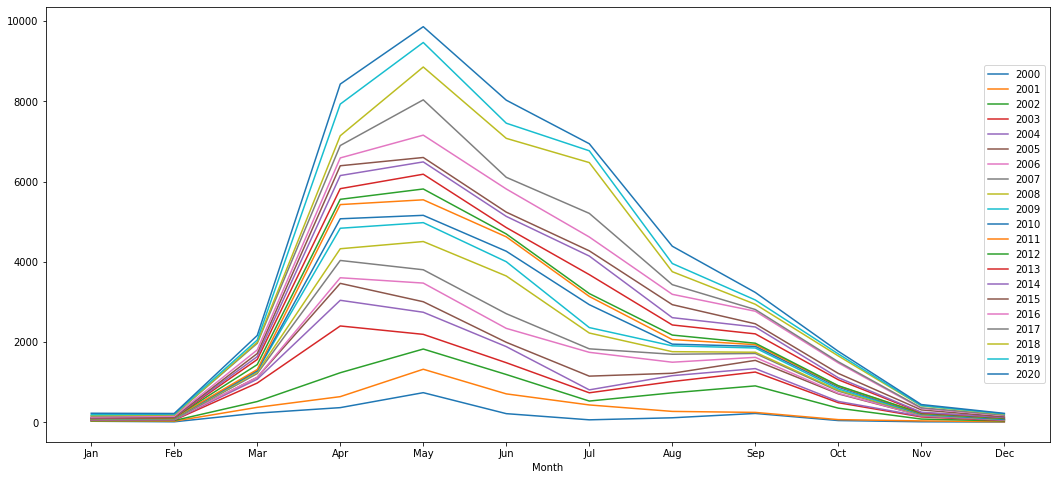

In [317]:
line = fig.plot(kind='line',y='fires', stacked=True)
line.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
line.set_xticklabels(fires_month['Month'].values)
line.legend(loc='center right')

In [209]:
fires_month = pd.DataFrame(columns=['Month','Sum'])
fires_month

Empty DataFrame
Columns: [Month, Sum]
Index: []

In [210]:

fires_month['Sum'] = firesAndDates['Month'].value_counts().to_frame()


In [211]:
fires_month

Month    Sum
5    NaN  11052
4    NaN   9874
6    NaN   9092
7    NaN   7768
8    NaN   4946
9    NaN   3547
3    NaN   2630
10   NaN   1981
11   NaN    547
1    NaN    279
12   NaN    278
2    NaN    264

In [212]:
fires_month['Month_num'] = fires_month.index
fires_month

Month    Sum  Month_num
5    NaN  11052          5
4    NaN   9874          4
6    NaN   9092          6
7    NaN   7768          7
8    NaN   4946          8
9    NaN   3547          9
3    NaN   2630          3
10   NaN   1981         10
11   NaN    547         11
1    NaN    279          1
12   NaN    278         12
2    NaN    264          2

In [213]:
month_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
                9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


In [214]:
fires_month['Month'] = fires_month['Month_num'].apply(lambda x: month_labels[x])

In [215]:
fires_month

Month    Sum  Month_num
5    May  11052          5
4    Apr   9874          4
6    Jun   9092          6
7    Jul   7768          7
8    Aug   4946          8
9    Sep   3547          9
3    Mar   2630          3
10   Oct   1981         10
11   Nov    547         11
1    Jan    279          1
12   Dec    278         12
2    Feb    264          2

In [216]:
fires_month.sort_values(by=['Month_num'], inplace=True)
fires_month = fires_month.reset_index(drop=True)
fires_month

Month    Sum  Month_num
0    Jan    279          1
1    Feb    264          2
2    Mar   2630          3
3    Apr   9874          4
4    May  11052          5
5    Jun   9092          6
6    Jul   7768          7
7    Aug   4946          8
8    Sep   3547          9
9    Oct   1981         10
10   Nov    547         11
11   Dec    278         12

In [217]:
fires_month.drop(columns=['Month_num'], inplace=True)


In [218]:
fires_month

Month    Sum
0    Jan    279
1    Feb    264
2    Mar   2630
3    Apr   9874
4    May  11052
5    Jun   9092
6    Jul   7768
7    Aug   4946
8    Sep   3547
9    Oct   1981
10   Nov    547
11   Dec    278

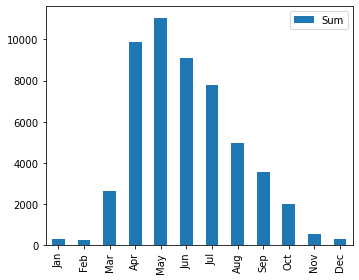

In [220]:
ax = fires_month.plot(kind="bar")
ax.set_xticklabels(fires_month['Month'].values)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [289]:
#At this point we remove Latitude and Longitude NaNs. We could replace these with other values in the future maybe?
sample = sample[sample['Latitude'].notna()]
sample = sample[sample['Longitude'].notna()]


In [290]:
#Group fires by size NEEDS TO CHANGE! Any ideas for groups?
small_wildfires = folium.FeatureGroup(TotArea = '< 5 Acres')
medium_wildfires = folium.FeatureGroup(TotArea = '100 - 500 Acres')
large_wildfires = folium.FeatureGroup(TotArea = '1000 - 5000 Acres')
xl_wildfires = folium.FeatureGroup(TotArea = '> 5000 Acres')

In [291]:
#Function that takes the dataframe and returns a map. Circles on the map are colored based on the size of the fire.
def add_ToHeatMap(fireCoords,map):
    map.add_child(plugins.HeatMap(fireCoords, radius=8.5))
    return map

In [292]:
#Function that takes the dataframe and returns a map. Circles on the map are colored based on the size of the fire.
def add_FireCircle(df, m):
    for i, v in df.iterrows():
        
        fire_size = float(v['Acres'])
        
        #When hoovering over the circle, the popup will show the fire name, year, cause, state and size.
        #More values can be added.
        popup = """
        Kommun : <b>%s</b><br>
        Size (Acres) : <b>%s</b><br>
        Cause : <b>%s</b><br>
        Year: <b>%s</b><br>
        """ % (v['kommunKortNamn'], v['Acres'], 
            v['BEJBbrandorsakText'], 
            v['ar'])
        
        
        if fire_size < 100:
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 0.8,
                            weight = 0,
                            tooltip = popup,
                            color = '#ffeda0',
                            fill_color = '#ffeda0',
                            fill_opacity = 0.7,
                            fill = True).add_to(small_wildfires)
            
        if fire_size in range(100, 500):
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size),
                            weight = 0,
                            tooltip = popup,
                            color = '#feb24c',
                            fill_color = '#feb24c',
                            fill_opacity = 0.7,
                            fill = True).add_to(medium_wildfires)
        
        if fire_size in range(1000, 5000):
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 1.5,
                            weight = 0,
                            tooltip = popup,
                            color = '#fc4e2a',
                            fill_color = '#fc4e2a',
                            fill_opacity = 0.7,
                            fill = True).add_to(large_wildfires)

        if fire_size > 5000:
            folium.CircleMarker(location = [v['Latitude'], 
                                            v['Longitude']],
                            radius = np.log(fire_size) * 2,
                            weight = 0,
                            tooltip = popup,
                            color = '##b10026',
                            fill_color = '#b10026',
                            fill_opacity = 0.7,
                            fill = True).add_to(xl_wildfires)

    small_wildfires.add_to(m)
    medium_wildfires.add_to(m)
    large_wildfires.add_to(m)
    xl_wildfires.add_to(m)
    folium.LayerControl(collapsed = False).add_to(m)

    return m

In [294]:
#Map instanciation, with start point at the center of Sweden. Type of map is set to Stamen Terrain and zoom is set to 5.5 in the beginning.
map = folium.Map(location = [59.334591, 18.063240],
               tiles = 'Stamen Terrain',
               zoom_start = 5.5)

In [297]:
#Creating Ciricle map (FYI! Can take som time!)
m_sweden = add_FireCircle(sample, map)
m_sweden.save('sweden.html')

In [295]:
#Creating heatmap for sample
locations = sample[['Latitude','Longitude']]
h_sweden = add_ToHeatMap(locations.values,map)

In [298]:
h_sweden